# Decomposotion on the NZERTF data

In [196]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import STL

import DataRetriever as dr

retriever = dr.DataRetriever()
year2 = retriever.get_data("All-Subsystems-hour-Year2.pkl")

In [197]:
gen_year2 = year2[year2["PV_Watts3PhTotalW3PhT1"].isna() == False]
gen_year2 = gen_year2[gen_year2["PV_Watts3PhTotalW3PhT2"].isna() == False] #There are 87 rows with NaN values.

print(f"A total of {len(year2) - len(gen_year2)} rows have been dropped since they have NaN values.")

gen_year2["Generated Energy"] = (gen_year2["PV_Watts3PhTotalW3PhT1"].to_numpy() + gen_year2["PV_Watts3PhTotalW3PhT2"].to_numpy())
gen_year2 = gen_year2[["Generated Energy"]] / 1e3 #Convert Wh to kWh

gen_year2 = gen_year2.resample("D").sum()

gen_year2

A total of 87 rows have been dropped since they have NaN values.


,Generated Energy
Timestamp,
2015-02-01,12.958986
2015-02-02,0.010302
2015-02-03,41.425352
2015-02-04,40.553641
2015-02-05,42.718180
...,...
2016-01-27,33.832924
2016-01-28,43.440532
2016-01-29,27.944539


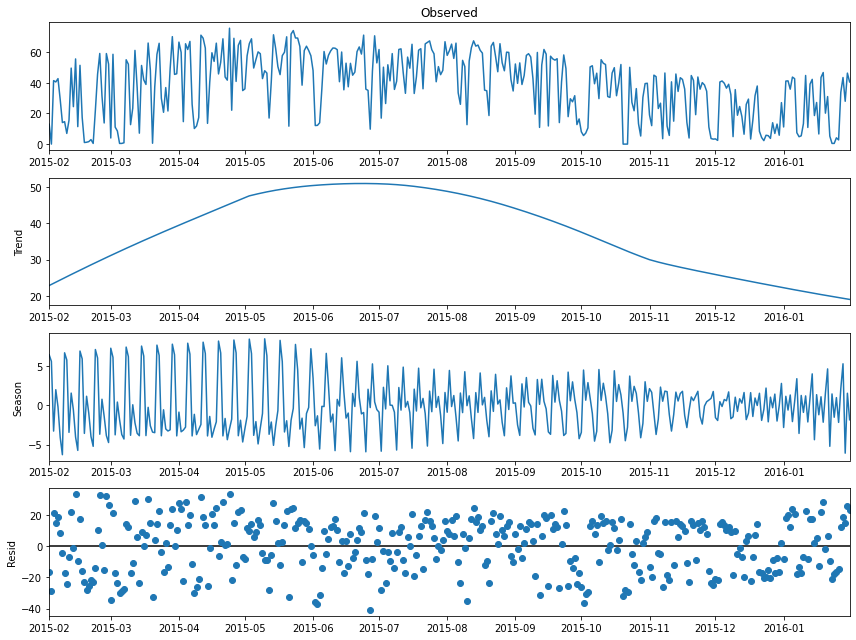

In [205]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 9]

decomp = STL(gen_year2, trend=183, seasonal=31 ).fit() #31 because we have daily data, which should show a monthly pattern.
decomp.plot()
plt.show()

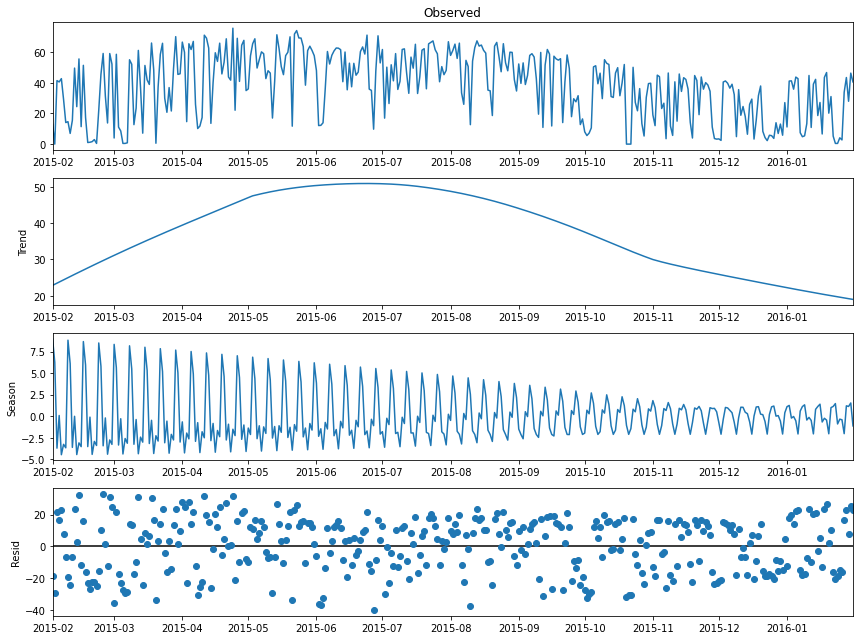

In [206]:
decomp = STL(gen_year2, trend=183, seasonal=93).fit() #31 because we have daily data, which should show a monthly pattern.
decomp.plot()
plt.show()

In [199]:
decomp_data = {"Observed": gen_year2["Generated Energy"],
               "Trend": decomp.trend,
               "Seasonal": decomp.seasonal,
               "Residuals": decomp.resid,
               # "Additive TS": decomp.trend + decomp.seasonal + decomp.resid,
               # "Multiplicative TS": np.log2(decomp.trend + decomp.seasonal + decomp.resid)
               }

decomp_df = pd.concat(decomp_data, axis=1)
decomp_df

,Observed,Trend,Seasonal,Residuals
Timestamp,,,,
2015-02-01,12.958986,18.358609,6.692843,-12.092467
2015-02-02,0.010302,18.762352,5.754373,-24.506424
2015-02-03,41.425352,19.166289,-3.191136,25.450198
2015-02-04,40.553641,19.570441,1.971950,19.011250
2015-02-05,42.718180,19.974813,-0.306253,23.049621
...,...,...,...,...
2016-01-27,33.832924,21.604776,2.168513,10.059635
2016-01-28,43.440532,21.575810,5.262849,16.601872
2016-01-29,27.944539,21.547996,-6.163877,12.560420


In [200]:
names = [col_name for col_name in decomp_df.columns]

fig = make_subplots(rows = 4, cols = 1,
                    subplot_titles = names,
                    shared_xaxes = True)

row = 1
col = 1

for component in list(decomp_df.columns):
    fig.add_trace(go.Scatter(
        x = decomp_df.index,
        y = decomp_df[component],
    ), row = row, col = col)
    row += 1

fig.update_layout(
    showlegend = False,
    height = 600
)

fig.show()

In [201]:
decomp_df.columns

Index(['Observed', 'Trend', 'Seasonal', 'Residuals'], dtype='object')